In [26]:
from fears.population import Population
from fears.experiment import Experiment
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fears.utils import stats, plotter, pharm
import scipy.stats as spstats
import os

# k_abs = [0.005,0.007,0.009,0.011]

# for k in k_abs:
#     p = Population(death_model = 'pharmacodynamic',n_sims=1,max_dose=10**2,n_timestep=500,dwell=True,dwell_time=24*4,k_abs=k,k_elim=0)
#     p.simulate()
np.random.seed(2024)

init_counts = np.zeros(16)
init_counts[0] = 10**5

options = {
    'mut_rate':10**-9,
    'fitness_data':'from_file',
    'use_carrying_cap':True,
    'carrying_cap':10**8,
    'dwell':True,
    'dwell_time':24*4,
    'death_model':'pharmacodynamic',
    'n_timestep':700,
    'plot':False,
    'k_abs':4.61,
    'k_elim':0.63,
    'max_dose':40,
    'regimen_length':10*24,
    'dose_schedule':8
}

eq_times = [1,2*24,4*24,8*24]
n_sims = 10
debug=False

experiment_type = 'equilibrium-time'

e = Experiment(experiment_type=experiment_type,
                n_sims=n_sims,
                eq_times=eq_times,
                population_options = options,
                results_folder='results',
                debug=debug)
# p = np.array([0.0])

TypeError: fears.population.Population() got multiple values for keyword argument 'curve_type'

In [22]:
e.run_experiment()

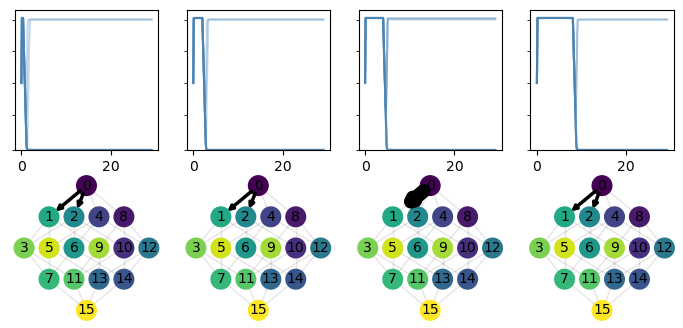

In [23]:
exp = pickle.load(open(e.experiment_info_path,'rb'))
# exp = pickle.load(open('./results/results_03062024_0000/experiment_info_03062024_0000.p','rb'))

p = exp.populations[0]

fig,ax_list = plt.subplots(ncols=4,nrows=2,figsize=(8.5,4))


km_data = stats.km_curve(exp=exp,resistance_outcome=[14,15])
prop_data1 = stats.n_mut_curve(exp=exp,nmut=1)
prop_data2 = stats.n_mut_curve(exp=exp,nmut=2)
prop_data3 = stats.n_mut_curve(exp=exp,nmut=3)

cmap = plt.get_cmap('Accent')

arrowprops = dict(arrowstyle='->', color='black', lw=1.5,mutation_scale=7,shrinkA=6,shrinkB=6)

landscape_options = {'node_size':200,
                    'square':True,'node_label':'base10','arrowprops':arrowprops,
                    'resize_param':0.01,'edge_alpha':0.1,'textsize':10}

cc = plotter.gen_color_cycler()
colors = cc.by_key()['color']
linestyles = cc.by_key()['linestyle']

for i in range(len(eq_times)):
    
    exp_folder = exp.exp_folders[i]
    sim_files = os.listdir(exp_folder)
    
    for sim_num in range(n_sims):
        ax = ax_list[0,i]
        y = stats.get_population_timetrace(sim_num=sim_num,condition_num=i,exp=exp)

        t = np.arange(len(y))/24

        ax.plot(t,y,color='steelblue',alpha=0.3)
        
        ax.set_yscale('symlog',linthresh=10**5)

        # ax = ax_list[1,i]

        # sim_path = os.path.join(exp_folder,sim_files[sim_num])
        # f = open(sim_path,'rb')
        # data = pickle.load(f)

        # data = data['counts']

        # data = np.divide(data.T,np.sum(data,axis=1)).T

        # for j in range(16):
        #     ax.plot(t,data[:,j],color=colors[j],alpha=0.3)
        
    
    ax_list[0,i].set_yticks([])
    # ax_list[1,i].set_yticks([])
        # ax.set_yscale('symlog',linthresh=10**-3)

    ###########################################################################
    ax = ax_list[1,i]
    traj_list = []
    for sim_num in range(n_sims):
        
        data = stats.get_sim_data(sim_num=sim_num,condition_num=i,exp=exp)
        trajectory = [0]
        for t in range(len(data[:,0])):
            pop = data[t,:]
            max_gen = np.argmax(pop)
            if max_gen != trajectory[-1]:
                trajectory.append(max_gen)

        if len(trajectory) > 1:
            traj_list.append(trajectory)

    # count the number of each unique trajectory
    
    traj_list = [tuple(traj) for traj in traj_list]

    traj_list_unique = list(set([tuple(traj) for traj in traj_list]))  
    
    traj_list_count = np.zeros((len(traj_list_unique)))
    
    for j,traj in enumerate(traj_list_unique):
        traj_list_count[j] = traj_list.count(traj)

    traj_list_count = 10*(np.array(traj_list_count)/np.sum(traj_list_count))**2

    traj_list_count[traj_list_count < 0.5] = 0.5

    plotter.plot_landscape(p,trajectory_list=traj_list_unique,conc=np.mean(p.drug_curve),ax=ax,
                           colorbar=False,weight_list=traj_list_count,**landscape_options)

    ###########################################################################
    

for ax in ax_list[0,1:]:
    ax.set_yticklabels([])

for ax in ax_list[0,:]:
    ax.set_ylim(-100,2*10**8)

fig.savefig('../figures/equilibrium_analysis.pdf',bbox_inches='tight')

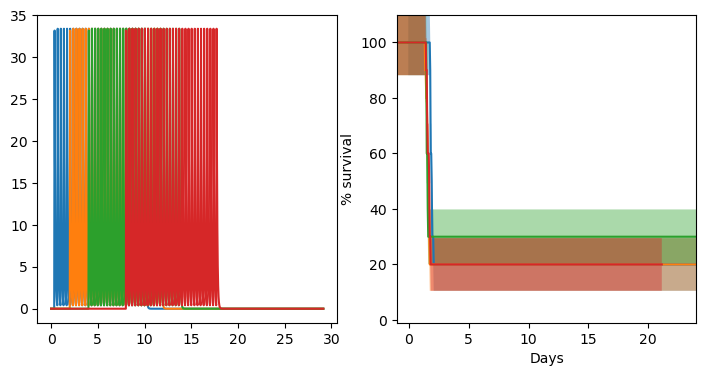

In [24]:
fig,ax_list = plt.subplots(ncols=2,figsize=(8.5,4))

for i in range(len(eq_times)):

    ax = ax_list[0]

    p = e.populations[i]
    t = np.arange(len(p.drug_curve))/24

    ax.plot(t,p.drug_curve)

    ax = ax_list[1]

    km_data_t = km_data[list(km_data.keys())[i]]['survival']

    t = np.arange(len(p.drug_curve))/24 - eq_times[i]/24

    plotter.plot_kaplan_meier(p,km_data_t,mode='survival',ax=ax,t_max=700,n_sims=n_sims,t_vect=t)

    ax.set_ylim(-1,110)
    ax.set_xlim(-1,24)

    ax.set_xticks([0,5,10,15,20])
    ax.set_xticklabels([0,5,10,15,20])

In [25]:
exp.exp_folders

['results/results_03192024_0004/eq_time=1',
 'results/results_03192024_0004/eq_time=48',
 'results/results_03192024_0004/eq_time=96',
 'results/results_03192024_0004/eq_time=192']